In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

def draw_graph(WINDOW):
    df = pd.read_csv("./data/02_시간별 제주 전력수요량.csv", encoding="UTF-8" )
    df["sum"] = df.sum( axis = 1, numeric_only=True)
    scaler = MinMaxScaler()
    scale_cols = ['1시', '2시', '3시', '4시', '5시', '6시', '7시', '8시', '9시', '10시', '11시', '12시', '13시', '14시', '15시', '16시', '17시', '18시', '19시', '20시', '21시', '22시', '23시', '24시', 'sum']
    df_scaled = scaler.fit_transform(df[scale_cols])
    df = pd.DataFrame(df_scaled, columns=scale_cols)
    new_column_names = {"날짜": "Date", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5", 6: "6", 7: "7", 8: "8", 9: "9", 10: "10", 11: "11", 12: "12", 13: "13", 14: "14", 15: "15", 16: "16", 17: "17", 18: "18", 19: "19", 20: "20", 21: "21", 22: "22", 23: "23", 24: "24"}
    df.rename(columns=new_column_names, inplace=True)
    class DemandDataset(Dataset):
        def __init__(self, df):
            self.data = df
            self.x = self.data.iloc[:, -1].values
        def __len__(self):
            return len(self.data)-WINDOW
        def __getitem__(self, idx):
            return self.x[idx:idx+WINDOW], self.x[idx+WINDOW]
    dataset = DemandDataset(df)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)
    class RNN(nn.Module):
        def __init__(self):
            super(RNN, self).__init__()
            self.rnn = nn.RNN(input_size=WINDOW, hidden_size=30, num_layers=2, batch_first=True)
            self.fc = nn.Linear(30, 1)
        def forward(self, x):
            x, _status = self.rnn(x)
            x = self.fc(x[:, -1])
            return x
    model = RNN()
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001)
    def compute_r2_score(y_true, y_pred):
        return r2_score(y_true.detach().cpu().numpy(), y_pred.detach().cpu().numpy())
    for epoch in range(200):
        for i, (x, y) in enumerate(dataloader):
            optimizer.zero_grad()
            output = model(x.unsqueeze(1).float())
            loss = criterion(output.squeeze(), y.float())
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0:
            y_true = y.float().unsqueeze(1)  
            y_pred = model(x.unsqueeze(1).float())  
            r2 = compute_r2_score(y_true, y_pred.squeeze())
            print(f"Epoch {epoch}: Loss: {loss}, R-squared: {r2}")
    data = list(df["sum"].values)
    for i in range(40000):
        x = data[0+i:i+WINDOW]
        output = model(torch.tensor(x).unsqueeze(0).unsqueeze(1).float())
        if i>=5479-WINDOW:
            data.append(output.squeeze().detach().numpy().item())
    plt.plot(data)
    plt.plot(df["sum"], label="실제")
    for i in range(0, len(data), 5479):
        plt.axvline(x=i, color="black", linestyle="--")

    torch.save(model, "model.pth")

Epoch 0: Loss: 0.011187387630343437, R-squared: 0.5959716971778766
Epoch 10: Loss: 0.0032411557622253895, R-squared: 0.8457972713052663
Epoch 20: Loss: 0.0037698778323829174, R-squared: 0.8917199028655591
Epoch 30: Loss: 0.0015855194069445133, R-squared: 0.9364562607740485
Epoch 40: Loss: 0.0010283029405400157, R-squared: 0.9434474955478606
Epoch 50: Loss: 0.0008490601903758943, R-squared: 0.9636209627356818
Epoch 60: Loss: 0.0014271469553932548, R-squared: 0.9440142948302137
Epoch 70: Loss: 0.0013604566920548677, R-squared: 0.9557494482339753
Epoch 80: Loss: 0.0011954661458730698, R-squared: 0.9572483448462001
Epoch 90: Loss: 0.0007532350718975067, R-squared: 0.9774296543240986
Epoch 100: Loss: 0.002029877156019211, R-squared: 0.9331429357772216
Epoch 110: Loss: 0.0015613201539963484, R-squared: 0.9568653596904023
Epoch 120: Loss: 0.0005908880848437548, R-squared: 0.9780836942402694
Epoch 130: Loss: 0.0012197180185467005, R-squared: 0.9547343681847115
Epoch 140: Loss: 0.00079129461664

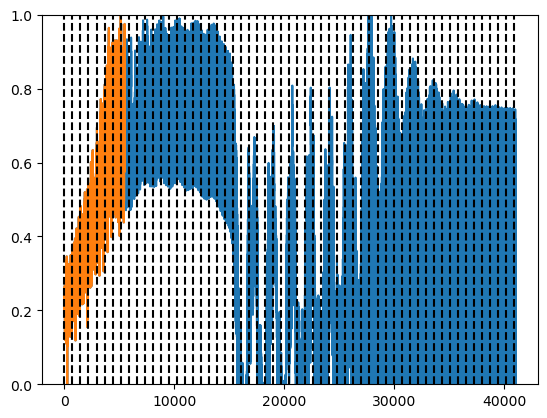

In [26]:
draw_graph(1000) # 3년 

Epoch 0: Loss: 0.006840474903583527, R-squared: 0.7387738555626149
Epoch 10: Loss: 0.0024246794637292624, R-squared: 0.9045537180974832
Epoch 20: Loss: 0.00310264783911407, R-squared: 0.9197527963142915
Epoch 30: Loss: 0.0014489011373370886, R-squared: 0.9484442464818579
Epoch 40: Loss: 0.0024211613927036524, R-squared: 0.8918836691104366
Epoch 50: Loss: 0.0016013884451240301, R-squared: 0.9347840002262565
Epoch 60: Loss: 0.0015061080921441317, R-squared: 0.9307858894886624
Epoch 70: Loss: 0.0009572558919899166, R-squared: 0.9605996827975636
Epoch 80: Loss: 0.0014360659988597035, R-squared: 0.9457133404641839
Epoch 90: Loss: 0.0023226917255669832, R-squared: 0.9049250785514389
Epoch 100: Loss: 0.0009026099578477442, R-squared: 0.9301712693896851
Epoch 110: Loss: 0.0011545674642547965, R-squared: 0.9560955054243222
Epoch 120: Loss: 0.00231191236525774, R-squared: 0.9282235164434615
Epoch 130: Loss: 0.0006650467403233051, R-squared: 0.9720362823416181
Epoch 140: Loss: 0.00147109222598373

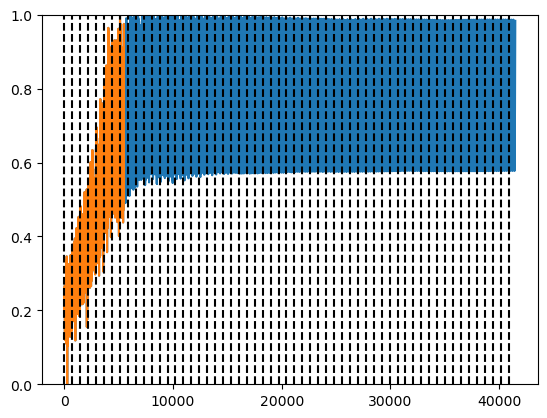

In [27]:
draw_graph(1500)

Epoch 0: Loss: 0.30956462025642395, R-squared: -9.049452441716378
Epoch 10: Loss: 0.01038266345858574, R-squared: 0.685185383624265
Epoch 20: Loss: 0.006365893874317408, R-squared: 0.7167502605297313
Epoch 30: Loss: 0.004609288647770882, R-squared: 0.7714804454209816
Epoch 40: Loss: 0.003257050644606352, R-squared: 0.8616362198321179
Epoch 50: Loss: 0.005159441381692886, R-squared: 0.7500292949679398
Epoch 60: Loss: 0.003486362751573324, R-squared: 0.8927648107472841
Epoch 70: Loss: 0.002585288370028138, R-squared: 0.8694637821482267
Epoch 80: Loss: 0.0015995744615793228, R-squared: 0.8996274984640524
Epoch 90: Loss: 0.003891221946105361, R-squared: 0.848012250670681
Epoch 100: Loss: 0.0028947601094841957, R-squared: 0.8674023024371793
Epoch 110: Loss: 0.0025236052460968494, R-squared: 0.8787322520220492
Epoch 120: Loss: 0.0024506310001015663, R-squared: 0.8958039237942085
Epoch 130: Loss: 0.004111104644834995, R-squared: 0.8930734210368411
Epoch 140: Loss: 0.0021290634758770466, R-squ

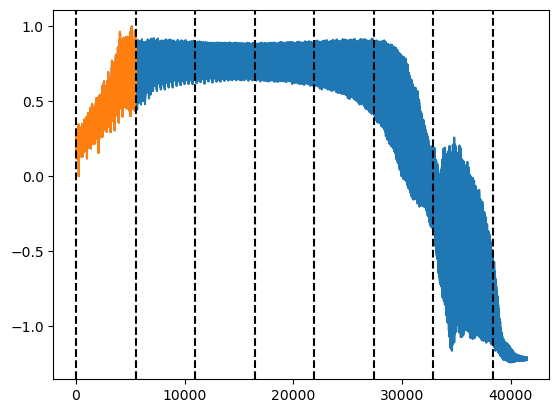

In [29]:
draw_graph(1500)

Epoch 0: Loss: 0.02731247805058956, R-squared: -0.025131889128272578
Epoch 10: Loss: 0.009918799623847008, R-squared: 0.5404439154777895
Epoch 20: Loss: 0.003950675018131733, R-squared: 0.8091902921622394
Epoch 30: Loss: 0.0032239085994660854, R-squared: 0.8507097108177633
Epoch 40: Loss: 0.004692479036748409, R-squared: 0.8164788098719226
Epoch 50: Loss: 0.004432864487171173, R-squared: 0.7553653885133054
Epoch 60: Loss: 0.004119933117181063, R-squared: 0.767186046306149
Epoch 70: Loss: 0.0050048185512423515, R-squared: 0.7401478764132794
Epoch 80: Loss: 0.003838140983134508, R-squared: 0.8399729570139172
Epoch 90: Loss: 0.0027218260802328587, R-squared: 0.8868951237432272
Epoch 100: Loss: 0.0028861169703304768, R-squared: 0.8378107546717406
Epoch 110: Loss: 0.0022032938431948423, R-squared: 0.9066611105904543
Epoch 120: Loss: 0.003263175254687667, R-squared: 0.8347326375454973
Epoch 130: Loss: 0.0029261892195791006, R-squared: 0.849527473905473
Epoch 140: Loss: 0.0014751621056348085,

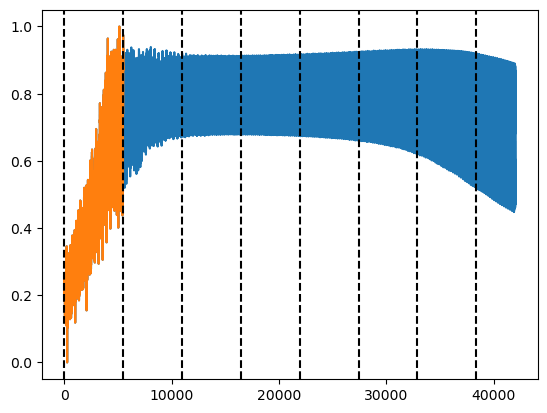

In [30]:
draw_graph(2000)

Epoch 0: Loss: 0.36178144812583923, R-squared: -26.284344038904994
Epoch 10: Loss: 0.009434081614017487, R-squared: 0.3720791968430237
Epoch 20: Loss: 0.005648283287882805, R-squared: 0.6084901679822283
Epoch 30: Loss: 0.005623324308544397, R-squared: 0.5580956136802158
Epoch 40: Loss: 0.004258141387254, R-squared: 0.6548884087933997
Epoch 50: Loss: 0.003415120067074895, R-squared: 0.6462320896080787
Epoch 60: Loss: 0.004225625656545162, R-squared: 0.7438332605730449
Epoch 70: Loss: 0.0034661456011235714, R-squared: 0.7092051089972433
Epoch 80: Loss: 0.004449808970093727, R-squared: 0.8155189108119543
Epoch 90: Loss: 0.004006918985396624, R-squared: 0.7471289049745193
Epoch 100: Loss: 0.0028447317890822887, R-squared: 0.8303245081510388
Epoch 110: Loss: 0.004242736846208572, R-squared: 0.6285331917697949
Epoch 120: Loss: 0.001947763143107295, R-squared: 0.8724136090305884
Epoch 130: Loss: 0.0033928388729691505, R-squared: 0.6316684555844505
Epoch 140: Loss: 0.0034987314138561487, R-squ

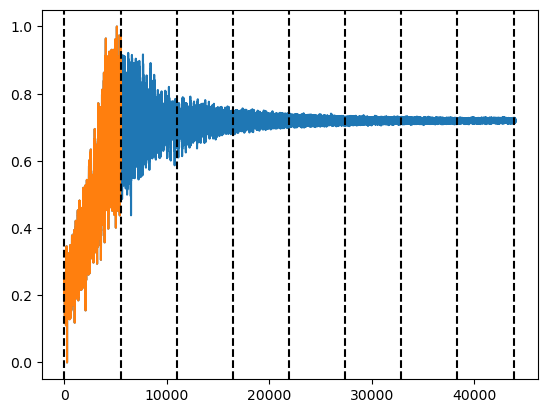

In [31]:
draw_graph(4000)

Epoch 0: Loss: 0.03280733898282051, R-squared: -0.24831379653875518


Epoch 10: Loss: 0.0065982285887002945, R-squared: 0.6270580894754743
Epoch 20: Loss: 0.003079547081142664, R-squared: 0.7943925084978372
Epoch 30: Loss: 0.002292514545843005, R-squared: 0.9158728123630211
Epoch 40: Loss: 0.0039567709900438786, R-squared: 0.8469412114022139
Epoch 50: Loss: 0.00222485838457942, R-squared: 0.8887348531889586
Epoch 60: Loss: 0.005199917126446962, R-squared: 0.787049619682532
Epoch 70: Loss: 0.0045829168520867825, R-squared: 0.8379875350867978
Epoch 80: Loss: 0.00255975010804832, R-squared: 0.8615563270510812
Epoch 90: Loss: 0.0024554473347961903, R-squared: 0.8940737895845675
Epoch 100: Loss: 0.004479546565562487, R-squared: 0.8459318594620382
Epoch 110: Loss: 0.0015399015974253416, R-squared: 0.9423638711961656
Epoch 120: Loss: 0.005366287659853697, R-squared: 0.7758231585500885
Epoch 130: Loss: 0.0012824644800275564, R-squared: 0.9349147208648464
Epoch 140: Loss: 0.002637611934915185, R-squared: 0.9195073230860419
Epoch 150: Loss: 0.002573063364252448, R

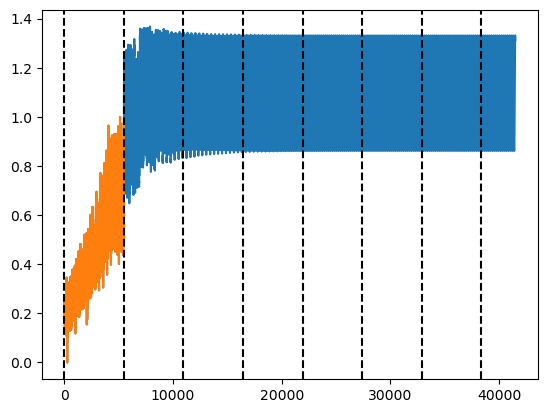

In [35]:
draw_graph(1500)

Epoch 0: Loss: 0.002609893213957548, R-squared: 0.8513655622847082
Epoch 10: Loss: 0.0026032370515167713, R-squared: 0.9580508730778583
Epoch 20: Loss: 0.0007301030564121902, R-squared: 0.9817564056792906
Epoch 30: Loss: 0.0007682946743443608, R-squared: 0.9642529527126508
Epoch 40: Loss: 0.0007922653458081186, R-squared: 0.9641664257191331
Epoch 50: Loss: 0.00033200092730112374, R-squared: 0.9763442936011857
Epoch 60: Loss: 0.0011403034441173077, R-squared: 0.9700883689857691
Epoch 70: Loss: 0.001823312253691256, R-squared: 0.7413910100334314
Epoch 80: Loss: 0.0028572280425578356, R-squared: 0.927522750609938
Epoch 90: Loss: 0.0012851922074332833, R-squared: 0.9498993111110637
Epoch 100: Loss: 0.0012528125662356615, R-squared: 0.941592130339386
Epoch 110: Loss: 0.002774827880784869, R-squared: 0.9737439793259205
Epoch 120: Loss: 0.0013542172964662313, R-squared: 0.9693704693736477
Epoch 130: Loss: 0.00104898726567626, R-squared: 0.9724520236868357
Epoch 140: Loss: 0.001481806510128080

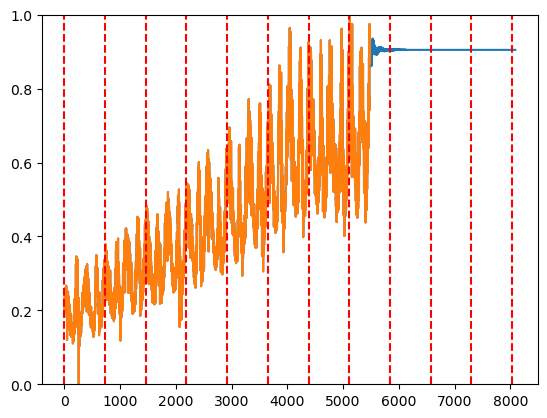

In [3]:
draw_graph(90)

Epoch 0: Loss: 0.006575718522071838, R-squared: 0.8707409435090034
Epoch 10: Loss: 0.0007576692150905728, R-squared: 0.9376058371729579
Epoch 20: Loss: 0.0008882833644747734, R-squared: 0.9770601785130419
Epoch 30: Loss: 0.0008259910391643643, R-squared: 0.913352339484256
Epoch 40: Loss: 0.0009415294043719769, R-squared: 0.9744599991937276
Epoch 50: Loss: 0.0028298310935497284, R-squared: 0.9258464961675228
Epoch 60: Loss: 0.0017021780367940664, R-squared: 0.9443929279060282
Epoch 70: Loss: 0.00103129877243191, R-squared: 0.9570619722546526
Epoch 80: Loss: 0.002459010574966669, R-squared: 0.9459865595411018
Epoch 90: Loss: 0.0009017750271596014, R-squared: 0.9690748984424978
Epoch 100: Loss: 0.0010325759649276733, R-squared: 0.9496150139019597
Epoch 110: Loss: 0.0014580958522856236, R-squared: 0.9665666694808166
Epoch 120: Loss: 0.0004922132357023656, R-squared: 0.9211961613013796
Epoch 130: Loss: 0.0007019364275038242, R-squared: 0.9771211075584538
Epoch 140: Loss: 0.00165400560945272

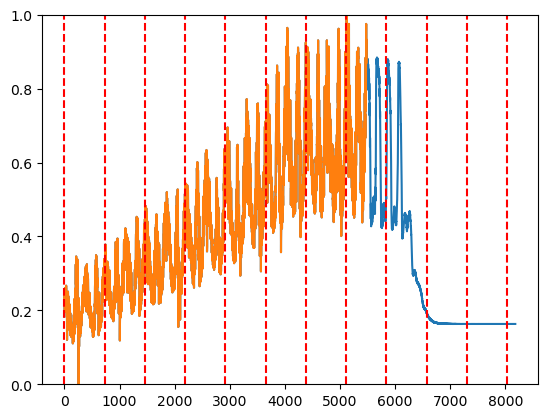

In [4]:
draw_graph(180)

Epoch 0: Loss: 0.030944200232625008, R-squared: -0.0022741728534121375
Epoch 10: Loss: 0.00298745883628726, R-squared: 0.8769830744478031
Epoch 20: Loss: 0.0018679641652852297, R-squared: 0.9176186483388203
Epoch 30: Loss: 0.0035038720816373825, R-squared: 0.9535711174490111
Epoch 40: Loss: 0.0014674104750156403, R-squared: 0.9134078375099643
Epoch 50: Loss: 0.001575371716171503, R-squared: 0.959201939598786
Epoch 60: Loss: 0.003061109920963645, R-squared: 0.9377431874386282
Epoch 70: Loss: 0.0018482840387150645, R-squared: 0.8430075016814222
Epoch 80: Loss: 0.0015660844510421157, R-squared: 0.9751527348652763
Epoch 90: Loss: 0.000828137737698853, R-squared: 0.9577478922580488
Epoch 100: Loss: 0.00141194649040699, R-squared: 0.849221430392974
Epoch 110: Loss: 0.001343537587672472, R-squared: 0.964943521173533
Epoch 120: Loss: 0.00359530420973897, R-squared: 0.9212084531209743
Epoch 130: Loss: 0.0011637546122074127, R-squared: 0.9327111768193458
Epoch 140: Loss: 0.0011527605820447206, R

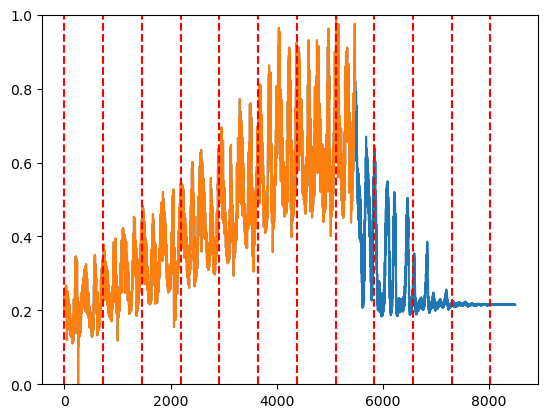

In [5]:
draw_graph(500)

Epoch 0: Loss: 0.04139089584350586, R-squared: -0.02308485372168101
Epoch 10: Loss: 0.04637501388788223, R-squared: -0.0038532197134699686
Epoch 20: Loss: 0.044673580676317215, R-squared: -0.141760686362975
Epoch 30: Loss: 0.028889959678053856, R-squared: -0.14246040010540884
Epoch 40: Loss: 0.023043038323521614, R-squared: -0.0033992676203247196
Epoch 50: Loss: 0.044576287269592285, R-squared: -0.0877638579383746
Epoch 60: Loss: 0.02323909103870392, R-squared: -0.011621596338624585
Epoch 70: Loss: 0.032168786972761154, R-squared: -0.09956467484966303
Epoch 80: Loss: 0.04024156928062439, R-squared: -0.05414620906947398
Epoch 90: Loss: 0.027254365384578705, R-squared: -0.21055695715737488
Epoch 100: Loss: 0.025714384391903877, R-squared: -0.0220064040138348
Epoch 110: Loss: 0.023750893771648407, R-squared: -0.0299864724852561
Epoch 120: Loss: 0.0243392176926136, R-squared: -0.25864300642684923
Epoch 130: Loss: 0.024439722299575806, R-squared: -0.01944526338703345
Epoch 140: Loss: 0.0538

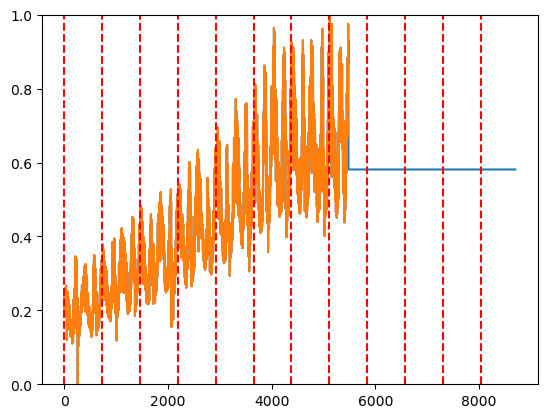

In [6]:
draw_graph(700)

Epoch 0: Loss: 0.03453182801604271, R-squared: 0.07723850711428804
Epoch 10: Loss: 0.00384849077090621, R-squared: 0.8398229052862759
Epoch 20: Loss: 0.002196543151512742, R-squared: 0.9282960350828557
Epoch 30: Loss: 0.002153233624994755, R-squared: 0.9199579119547177
Epoch 40: Loss: 0.0013433030107989907, R-squared: 0.9201407694810939
Epoch 50: Loss: 0.0028771129436790943, R-squared: 0.8025608600845469
Epoch 60: Loss: 0.00278856442309916, R-squared: 0.9144158125278328
Epoch 70: Loss: 0.000862356333527714, R-squared: 0.9434454293320584
Epoch 80: Loss: 0.002327089896425605, R-squared: 0.8140021079584746
Epoch 90: Loss: 0.0020020126830786467, R-squared: 0.9405702097484162
Epoch 100: Loss: 0.002376380143687129, R-squared: 0.9667110858311256
Epoch 110: Loss: 0.0007480736239813268, R-squared: 0.9531409794123878
Epoch 120: Loss: 0.0035233295056968927, R-squared: 0.9165720596535559
Epoch 130: Loss: 0.0013468906981870532, R-squared: 0.9552525347599604
Epoch 140: Loss: 0.0006651881849393249, R

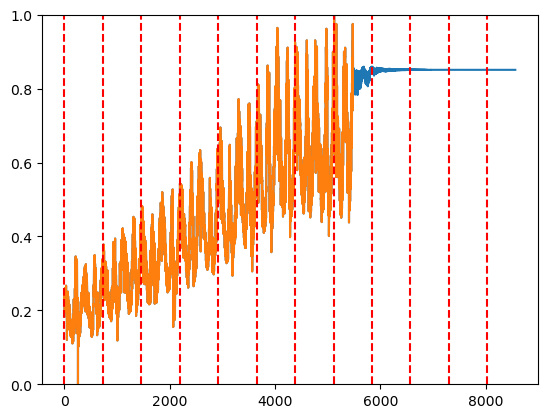

In [14]:
draw_graph(561)

Epoch 0: Loss: 0.018619000911712646, R-squared: 0.6805478622473389


Epoch 10: Loss: 0.0008404095424339175, R-squared: 0.9330760643854767
Epoch 20: Loss: 0.004478072747588158, R-squared: 0.9353713379254642
Epoch 30: Loss: 0.0017376443138346076, R-squared: 0.947878663526062
Epoch 40: Loss: 0.0024654055014252663, R-squared: 0.9815521072534413
Epoch 50: Loss: 0.002535299165174365, R-squared: 0.9555783343862261
Epoch 60: Loss: 0.0006904912879690528, R-squared: 0.949815463927761
Epoch 70: Loss: 0.0016341202426701784, R-squared: 0.9647574212689591
Epoch 80: Loss: 0.0024955563712865114, R-squared: 0.8843953455878455
Epoch 90: Loss: 0.0014184004394337535, R-squared: 0.9761877982524816
Epoch 100: Loss: 0.0009026671759784222, R-squared: 0.9466998650388135
Epoch 110: Loss: 0.0007436295272782445, R-squared: 0.9811942565860209
Epoch 120: Loss: 0.0021500815637409687, R-squared: 0.8835016715437086
Epoch 130: Loss: 0.003920184914022684, R-squared: 0.9190972082182646
Epoch 140: Loss: 0.0029261887539178133, R-squared: 0.9611355856362995
Epoch 150: Loss: 0.000996293500065

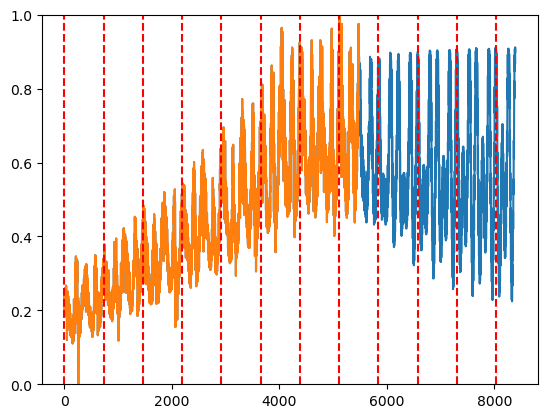

In [16]:
draw_graph(390)

Epoch 0: Loss: 0.0022809249348938465, R-squared: 0.9042110106067142


Epoch 10: Loss: 0.00242980825714767, R-squared: 0.9012420645697936
Epoch 20: Loss: 0.0007694538217037916, R-squared: 0.9779275316837369
Epoch 30: Loss: 0.0018694280879572034, R-squared: 0.8305722260943548
Epoch 40: Loss: 0.001986333169043064, R-squared: 0.9654473393992945
Epoch 50: Loss: 0.001308472128584981, R-squared: 0.9570321650765832
Epoch 60: Loss: 0.00815935805439949, R-squared: 0.9086014157935595
Epoch 70: Loss: 0.0007914930465631187, R-squared: 0.9559250972490385
Epoch 80: Loss: 0.003084555035457015, R-squared: 0.8469557905475857
Epoch 90: Loss: 0.001130368560552597, R-squared: 0.9541270090275858
Epoch 100: Loss: 0.0015320139937102795, R-squared: 0.9128716124829186
Epoch 110: Loss: 0.0016483009094372392, R-squared: 0.9351694712023471
Epoch 120: Loss: 0.00363836414180696, R-squared: 0.8769410173812517
Epoch 130: Loss: 0.001298898714594543, R-squared: 0.9361522030150713
Epoch 140: Loss: 0.0007119493093341589, R-squared: 0.9779443881058336
Epoch 150: Loss: 0.001212222850881517, R

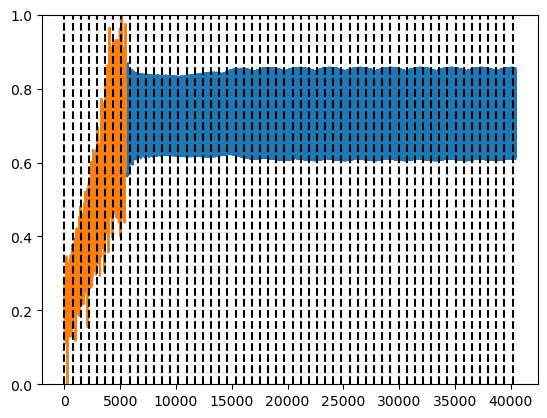

In [22]:
draw_graph(390)

Epoch 0: Loss: 0.025582056492567062, R-squared: -0.08580496812486937


Epoch 10: Loss: 0.049320634454488754, R-squared: -0.011465184496028735
Epoch 20: Loss: 0.038485027849674225, R-squared: -0.0006364714373487956
Epoch 30: Loss: 0.018647203221917152, R-squared: -0.043400579462367084
Epoch 40: Loss: 0.02231774665415287, R-squared: -0.06098220094562845
Epoch 50: Loss: 0.01964246854186058, R-squared: -0.016057133009073077
Epoch 60: Loss: 0.022322753444314003, R-squared: -0.0011259288730438577
Epoch 70: Loss: 0.02852814830839634, R-squared: -0.12973841199287617
Epoch 80: Loss: 0.022283382713794708, R-squared: -0.007766640947842962
Epoch 90: Loss: 0.019114729017019272, R-squared: -0.038062479997001075
Epoch 100: Loss: 0.022534441202878952, R-squared: -0.029680213868980898
Epoch 110: Loss: 0.025983572006225586, R-squared: -0.04130330068342647
Epoch 120: Loss: 0.03275596350431442, R-squared: -0.016942184761079337
Epoch 130: Loss: 0.026562174782156944, R-squared: -0.02168881564319669
Epoch 140: Loss: 0.02784419246017933, R-squared: -0.005707363646475061
Epoch 15

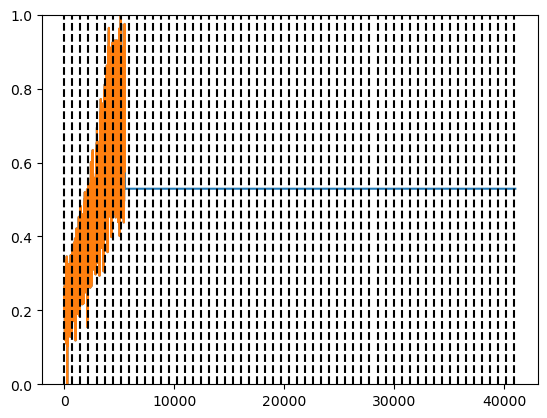

In [25]:
draw_graph(1000)